In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses
from tools.ae_v11 import Autoencoder
from tools.ESN_v4 import ESN
from tools.ESN_v4_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v4 import AR_AERNN_ESN as AR_AERNN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-27 08:13:32.456567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.456933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.495001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.495313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.495582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.497404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 08:13:32.498048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.498318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-27 08:13:32.498566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_049'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/ESN_params_Search/params_search_008
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_049
data_dir_idx: 000
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
lyapunov_time_arr = [13.06493504]

In [15]:
delta_t = 1.
T = t_recorded_samples[-1]

In [16]:
with np.load(dir_name_data+'/sim_data.npz', 'r') as f:
    delta_t = f['dTr']

In [17]:
print('all_data.shape : ', all_data.shape)

all_data.shape :  (100001, 2, 50, 50)


In [18]:
# delaing with normalizing the data before feeding into autoencoder
time_stddev_ogdata = np.std(all_data, axis=0)
time_mean_ogdata = np.mean(all_data, axis=0)
if use_ae_data == True:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]

In [19]:
a = 30000
all_data = all_data[0:a]
boundary_idx_arr = [a]

In [20]:
# all_data_shape_og = all_data.shape[1:]
print('all_data.shape : ', all_data.shape)

all_data.shape :  (30000, 2, 50, 50)


# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1:], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


2023-06-27 08:13:42.315588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
ls_shape = latent_states_all.shape[1:]

2023-06-27 08:13:43.863815: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 600000000 exceeds 10% of free system memory.
2023-06-27 08:13:44.266126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 600000000 exceeds 10% of free system memory.


In [24]:
num_latent_states = 1
for dim in ls_shape:
    num_latent_states *= dim
print('ls_shape : ', ls_shape)
print('num_latent_states : ', num_latent_states)

ls_shape :  (3, 3, 3)
num_latent_states :  27


# ESN

In [25]:
# RNN data parameters
dt_rnn = 0.5
num_input_tsteps = 10000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
print('ESN_layers_units : ', ESN_layers_units)
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

# saving simulation data
sim_data = {
    'T':T,
    'delta_t':delta_t,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

ESN_layers_units :  [540]


In [26]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [27]:
latent_states_all = np.reshape(latent_states_all, (-1, num_latent_states))
all_data = np.reshape(all_data, (all_data.shape[0], -1))

In [28]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    # params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [29]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [30]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    # params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [31]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 2

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [32]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
        AR_testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        AR_testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [33]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  10


In [34]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [35]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [36]:
AR_testing_data_rnn_input = np.reshape(
    AR_testing_data_rnn_input,
    (
        AR_testing_data_rnn_input.shape[0],
        AR_testing_data_rnn_input.shape[1],
    ) + tuple(all_data_shape_og)
)

AR_testing_data_rnn_output = np.reshape(
    AR_testing_data_rnn_output,
    (
        AR_testing_data_rnn_output.shape[0],
        AR_testing_data_rnn_output.shape[1],
    ) + tuple(all_data_shape_og)
)

In [37]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (5, 2000, 27)
  training_data_rnn_output.shape :  (5, 2000, 27)
    testing_data_rnn_input.shape :  (2, 2000, 27)
   testing_data_rnn_output.shape :  (2, 2000, 27)
        val_data_rnn_input.shape :  (0, 2000, 27)
       val_data_rnn_output.shape :  (0, 2000, 27)

 AR_testing_data_rnn_input.shape :  (10, 13, 2, 50, 50)
AR_testing_data_rnn_output.shape :  (10, 52, 2, 50, 50)


In [38]:
val_loss_hist = []
train_loss_hist = []

In [39]:
training_data_rnn_input.dtype

dtype('float32')

In [40]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=num_latent_states,
        ESN=ESN,
        AR_RNN=AR_RNN,
        AR_AERNN=AR_AERNN,
        ae_net=ae_net,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        AR_RNN,
        AR_AERNN,
        ae_net,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input,
        T_sample_output,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [41]:
fRMS_bounds = Real(1e-4, 1e-1, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
rho_res_bounds = Real(0.2, 1.2)
omega_in_bounds = Real(0.1, 2.5)
alpha_bounds = Real(0.5, 1.0)
degree_of_connectivity_bounds = Integer(1, 10)
acq_func = "EI"
n_initial_points = 50
n_calls = n_initial_points + 10

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'rho_res_bounds':rho_res_bounds,
    'omega_in_bounds':omega_in_bounds,
    'alpha_bounds':alpha_bounds,
    # 'degree_of_connectivity_bounds':degree_of_connectivity_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
if vary_deg_connect == True:
    optim_dict['degree_of_connectivity_bounds'] = degree_of_connectivity_bounds
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    rho_res_bounds,
    omega_in_bounds,
    alpha_bounds,
    # degree_of_connectivity_bounds
]
if vary_deg_connect == True:
    dimensions.append(degree_of_connectivity_bounds)

In [42]:
x0 = [fRMS_x0, lambda_reg_x0, rho_res_x0, omega_in_x0, alpha_x0]
if vary_deg_connect == True:
    x0.append(degree_of_connectivity_x0)

res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/2 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 5 -- Wout batch_time : 0.37 s -- eta : 0h 0m 1s
2 / 5 -- Wout batch_time : 0.28 s -- eta : 0h 0m 1s
3 / 5 -- Wout batch_time : 0.30 s -- eta : 0h 0m 1s
4 / 5 -- Wout batch_time : 0.29 s -- eta : 0h 0m 0s
5 / 5 -- Wout batch_time : 0.27 s -- eta : 0h 0m 0s

epoch_time : 1.5163023471832275 sec

val mse

training mse
1 / 5 -- batch_time : 0.2876472473144531 sec
2 / 5 -- batch_time : 0.19845128059387207 sec
3 / 5 -- batch_time : 0.21530961990356445 sec
4 / 5 -- batch_time : 0.20482397079467773 sec
5 / 5 -- batch_time : 0.26766085624694824 sec

train_mse : 0.0008080496219918131
val_mse : 0
val_mse improved from inf

Total epoch computation time : 2.693854808807373 sec

test mse
1 / 2
2 / 2
test_mse : 0.001281657896

In [43]:
res

          fun: -0.0
    func_vals: array([-0., -0.])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542)]
 random_state: RandomState(MT19937) at 0x7FF4FB5D1440
        space: Space([Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
       Real(low=1e-07, high=0.001, prior='log-uniform', transform='normalize'),
       Real(low=0.2, high=0.95, prior='uniform', transform='normalize'),
       Real(low=0.5, high=1.5, prior='uniform', transform='normalize'),
       Real(low=0.5, high=1.0, prior='uniform', transform='normalize')])
        specs: {'args': {'func': <function optim_func at 0x7ff4f029c3a0>, 'dimensions': Space([Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
       Real(low=1e-07, high=0.001, prior='log-uniform', transform='nor

In [44]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [45]:
optim_idx

0

/tmp/ipykernel_2584124/2178403340.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)


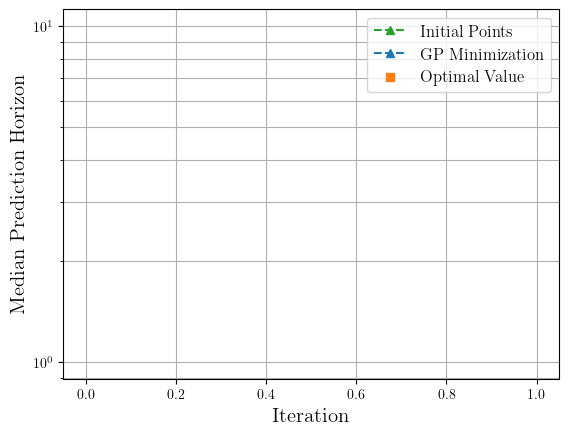

In [46]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

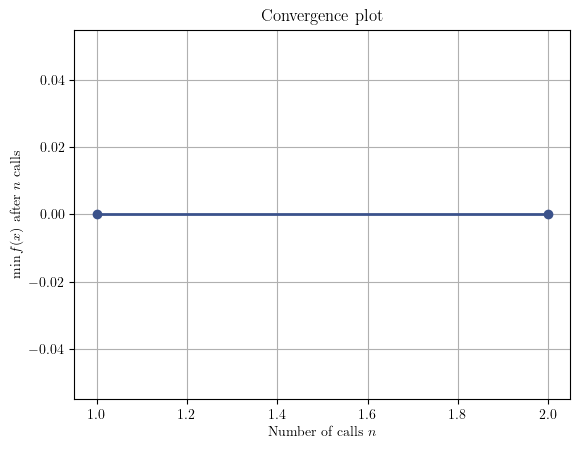

In [47]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [48]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

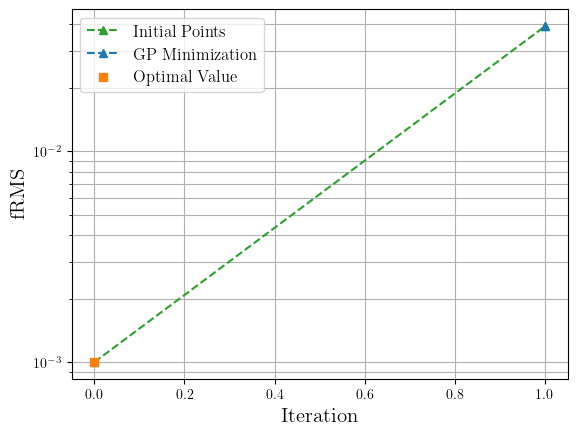

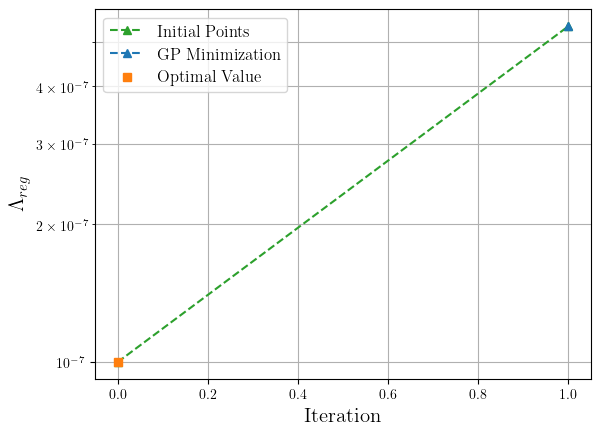

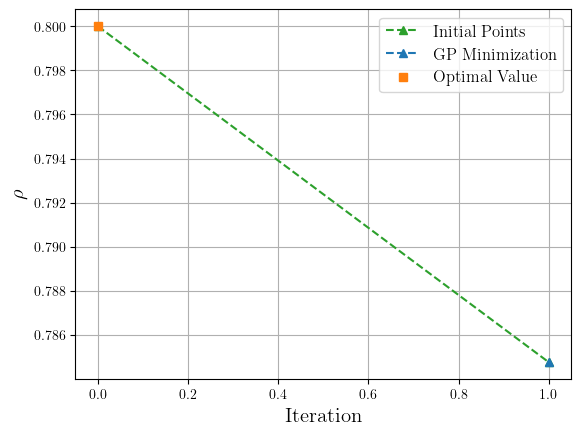

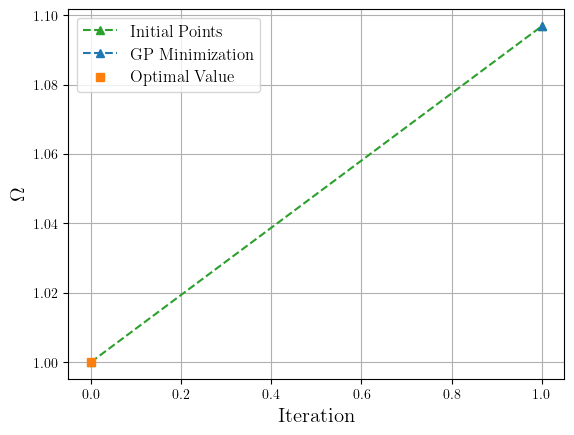

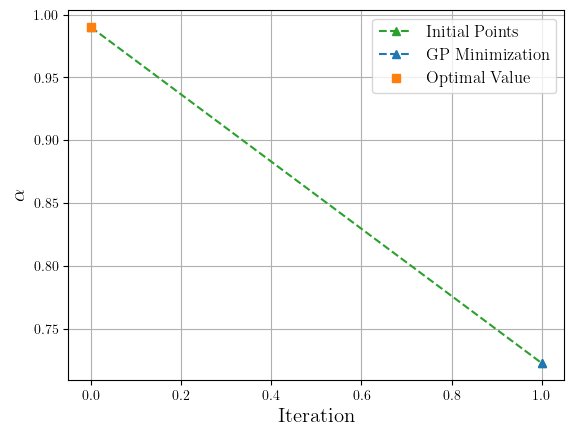

In [49]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
    # [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [50]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [51]:
ph_mean_lst = []
for dir_name in dir_list:
    files = [f for f in os.listdir(dir_name_rnn+'/tested_ESN/'+dir_name) if f.startswith('prediction_horizons')]
    fname = [f for f in files if f.endswith('.npz')][0]
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/'+fname) as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [52]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [53]:
idx, dir_list[idx[0]]

(array([0, 1]), 'test_ESN_000')

In [54]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

/tmp/ipykernel_2584124/1752661252.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)


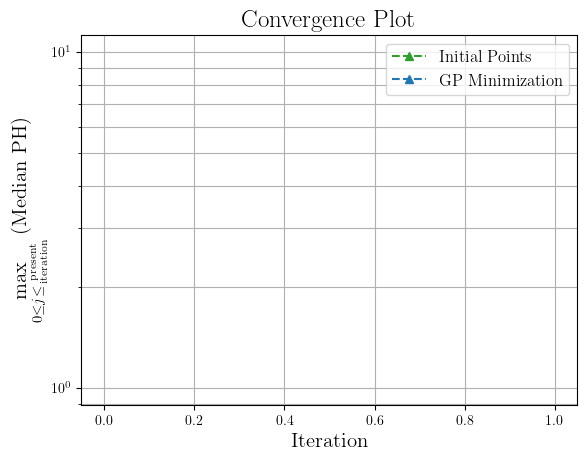

In [55]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation